### TABLE OF CONTENTS

- I.Data Import
- II. Data Exploration
- III. Train-Dev Split
- IV. Tokenization
- V. Embeddings
- VI. Performance Evaluation
- VII. DNN Model
- VIII. CNN Model
- IX. CNN + LSTM Model
- X. RNN BLSTM Models


### I. Data Import

Data Source:

Toxic Comment Classification Challenge

https://www.kaggle.com/competitions/jigsaw-toxic-comment-classification-challenge/data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
TRAIN_DATA_FILE= '/content/drive/MyDrive/ContentModerationProject/Final/train.csv'

In [ ]:
max_features = 20000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 50 # max number of words in a comment to use
embed_size = 100

In [ ]:
train = pd.read_csv(TRAIN_DATA_FILE)

In [ ]:
train.shape

(159571, 8)

In [ ]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


### II. Data Exploration

In [ ]:
# Check the dimensions
print(f"Number of rows: {train.shape[0]}\n"
      f"Number of columns: {train.shape[1]}")

# Check for missing values
print(f"Number of missing values: {train.isna().sum().sum()}")

Number of rows: 159571
Number of columns: 8
Number of missing values: 0


In [ ]:
# Inspect the classes
cols = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
classes = [train[col].value_counts(normalize = True) for col in cols]
pd.DataFrame(classes, index = cols)

,0,1
toxic,0.904156,0.095844
severe_toxic,0.990004,0.009996
obscene,0.947052,0.052948
threat,0.997004,0.002996
insult,0.950636,0.049364
identity_hate,0.991195,0.008805


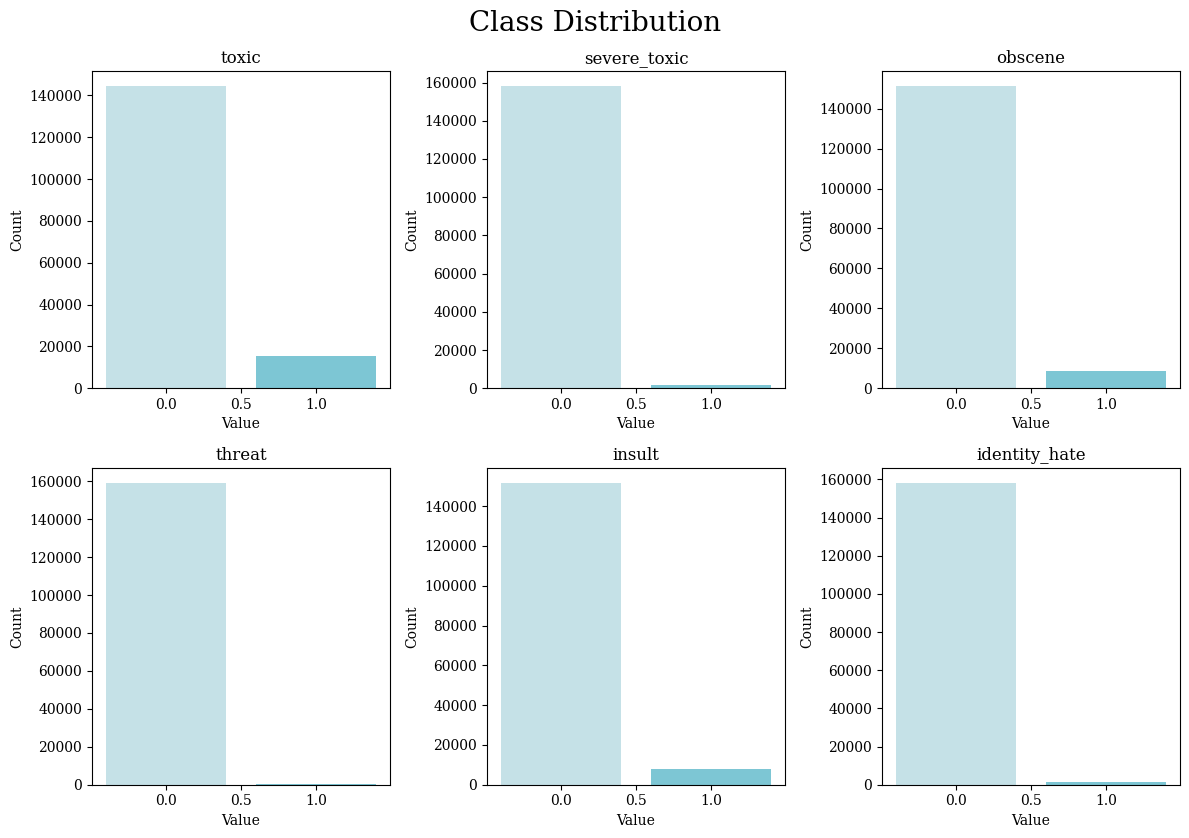

In [ ]:
# Set up the figure with subplots
plt.rcParams.update({"font.family": "serif"})
fig, axs = plt.subplots(nrows = 2, ncols = 3, figsize = (12, 8.5))

# Visualize the class distribution for each column
for i, col in enumerate(cols):
    counts = train[col].value_counts()
    axs[i // 3, i % 3].bar(counts.index, counts.values, color = ["#C5E1E7", "#7DC6D4"])
    axs[i // 3, i % 3].set_title(col)
    axs[i // 3, i % 3].set_xlabel("Value")
    axs[i // 3, i % 3].set_ylabel("Count")

# Display the plot
fig.suptitle("Class Distribution", size = 20) # Assign main title
fig.tight_layout()

### III. Train-Dev Split

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_dev, y_train, y_dev = train_test_split(train["comment_text"], train[cols], 
                                                  test_size = 0.2, random_state = 10)

In [ ]:
X_train = np.array(X_train).reshape(X_train.shape[0], 1)
X_dev = np.array(X_dev).reshape(X_dev.shape[0], 1)

In [ ]:
print(X_train.shape, X_dev.shape, y_train.shape, y_dev.shape)

(127656, 1) (31915, 1) (127656, 6) (31915, 6)


### IV. Tokenization

In [ ]:
import re
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
lemmatizer = WordNetLemmatizer()
sw = set(stopwords.words('english'))

In [ ]:
# Need to convert treebank_tag to wordnet tag before lemmatization
# reference code: https://stackoverflow.com/questions/15586721/wordnet-lemmatization-and-pos-tagging-in-python

def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

In [ ]:
def postag_lemmatize(t):
    l = []
    tagged_t = nltk.pos_tag(t)
    for word, tag in tagged_t:
        wntag = get_wordnet_pos(tag)
        if wntag is None:
            l.append(lemmatizer.lemmatize(word))
        else:
            l.append(lemmatizer.lemmatize(word, pos=wntag))
    return l 

In [ ]:
def text_clean(t):
    t = re.sub(r'\n', ' ', t)
    t = re.sub(r'\t', ' ', t)
    t = t.lower()
    t = re.sub('[^a-z]', ' ', t)
    t = t.split()
    t = postag_lemmatize(t)
    t = [w for w in t if w not in sw]
    return t

In [ ]:
comment_list_train = [str(item[0]) for item in X_train.tolist()]
comment_list_dev = [str(item[0]) for item in X_dev.tolist()]

In [ ]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(comment_list_train)

In [ ]:
tokens_train = tokenizer.texts_to_sequences(comment_list_train)
tokens_dev = tokenizer.texts_to_sequences(comment_list_dev)

In [ ]:
tokens_train = pad_sequences(tokens_train, maxlen=maxlen)
tokens_dev = pad_sequences(tokens_dev, maxlen=maxlen)

In [ ]:
word_index = tokenizer.word_index

In [ ]:
print(tokens_train.shape, tokens_dev.shape)

(127656, 50) (31915, 50)


### V. Embeddings

In [ ]:
!wget http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
!unzip /content/glove.6B.zip

--2023-06-08 12:27:21--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.09MB/s    in 2m 40s  

2023-06-08 12:30:01 (5.13 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]

Archive:  /content/glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [ ]:
EMBEDDING_FILE= 'glove.6B.100d.txt'

In [ ]:
def build_word_dict(d, file):
    with open(file, 'r') as f:
        for line in f.readlines(): # read the file line by line
            line = line.split(' ') # split each line by space

            try:
                d[line[0]] = np.array(line[1:], dtype = 'float32') 
                # line[0] is the word, which is the key of the dictionary
                # line[1:] are embeddings, which is the value of the dictionary
            except: 
                continue

In [ ]:
embeddings_dict = dict()
build_word_dict(embeddings_dict, EMBEDDING_FILE)

In [ ]:
#Normalization
embed_vals = np.stack(embeddings_dict.values())
embed_mean, embed_std = embed_vals.mean(), embed_vals.std()
print(embed_mean, embed_std)

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


0.004451992 0.4081574


In [ ]:
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(embed_mean, embed_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_dict.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

### VI. Performance Evaluation

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [ ]:
def float_array_to_binary(float_array, threshold):
    binary_array = np.where(np.array(float_array) >=  threshold, 1, 0)
    return binary_array

In [ ]:
def chooseThreshold(subtype, true, pred, plot = True):
    max_f1 = 0
    argmax_f1 = 0
    accuracy_list = []
    recall_list = []
    precision_list = []
    f1_list = []
    thres_list = np.arange(0.1, 1.0, 0.1)

    for i in thres_list:
        i = round(i, 2)
        pred_i = float_array_to_binary(pred, i)
        accuracy = accuracy_score(true, pred_i)
        accuracy_list.append(accuracy)
        recall = recall_score(true, pred_i)
        recall_list.append(recall)
        precision = precision_score(true, pred_i)
        precision_list.append(precision)
        f1 = f1_score(true, pred_i)
        f1_list.append(f1)
        if f1 > max_f1:
            max_f1 = f1
            argmax_f1 = i
    
    if plot:
        plt.plot(thres_list, accuracy_list, label ='accuracy')
        plt.plot(thres_list, recall_list, '-.', label ='recall')
        plt.plot(thres_list, precision_list, '-', label ='precision')
        plt.plot(thres_list, f1_list, ':', label ='f1')
        plt.plot(argmax_f1, max_f1,'bo-')
        label = "(" + str(argmax_f1) + ", " + str(round(max_f1,2)) + ")"
        plt.annotate(label, (argmax_f1, max_f1), textcoords="offset points",
                        xytext=(0,10), ha='center') 

        plt.xlabel("threshold")
        plt.ylabel("performance")
        plt.legend()
        plt.title(subtype + ' Subtype : Performance At Different Threshold')
        plt.show()
    return argmax_f1, max_f1

In [ ]:
def metrics(pred, true):
    conf_matrix = confusion_matrix(true, pred)
    tn, fp, fn, tp = conf_matrix.ravel()
    accuracy = accuracy_score(true, pred)
    precision = precision_score(true, pred)
    recall = recall_score(true, pred)
    f1 = f1_score(true, pred)
    return round(accuracy,4), round(precision,4), round(recall,4), round(f1,4)

In [ ]:
def Model_OverallPerformance(y_pred, y_true, adjustThreshold = True, Thresholdplot = False):
    y_true_toxic = [row[0] for row in y_true]
    y_true_severe_toxic = [row[1] for row in y_true]
    y_true_obscene  = [row[2] for row in y_true]
    y_true_threat = [row[3] for row in y_true]
    y_true_insult = [row[4] for row in y_true]
    y_true_identity_threat = [row[5] for row in y_true]

    y_pred_toxic = [row[0] for row in y_pred]
    y_pred_severe_toxic = [row[1] for row in y_pred]
    y_pred_obscene  = [row[2] for row in y_pred]
    y_pred_threat = [row[3] for row in y_pred]
    y_pred_insult = [row[4] for row in y_pred]
    y_pred_identity_threat = [row[5] for row in y_pred]

    if adjustThreshold:
        thresh_toxic, f1_toxic = chooseThreshold('Toxic', y_true_toxic, y_pred_toxic, Thresholdplot)
        thresh_severe_toxic, f1_severe_toxic = chooseThreshold('Severe Toxic', y_true_severe_toxic, y_pred_severe_toxic, Thresholdplot)
        thresh_obscene, f1_obscene = chooseThreshold('Obsence', y_true_obscene, y_pred_obscene, Thresholdplot)
        thresh_threat, f1_threat = chooseThreshold('Threat', y_true_threat, y_pred_threat, Thresholdplot)
        thresh_insult, f1_insult = chooseThreshold('Insult', y_true_insult, y_pred_insult, Thresholdplot)
        thresh_identity_threat, f1_identity_threat = chooseThreshold('Identity Threat', y_true_identity_threat, y_pred_identity_threat, Thresholdplot)

        y_pred_toxic = float_array_to_binary(y_pred_toxic, thresh_toxic)
        y_pred_severe_toxic = float_array_to_binary(y_pred_severe_toxic, thresh_severe_toxic)
        y_pred_obscene = float_array_to_binary(y_pred_obscene, thresh_obscene)
        y_pred_threat = float_array_to_binary(y_pred_threat, thresh_threat)
        y_pred_insult = float_array_to_binary(y_pred_insult, thresh_insult)
        y_pred_identity_threat = float_array_to_binary(y_pred_identity_threat, thresh_identity_threat)

    accuracy_toxic, precision_toxic, recall_toxic, f1_toxic = metrics(y_pred_toxic, y_true_toxic)
    accuracy_severe_toxic, precision_severe_toxic, recall_severe_toxic, f1_severe_toxic = metrics(y_pred_severe_toxic, y_true_severe_toxic)
    accuracy_obscene, precision_obscene, recall_obscene, f1_obscene = metrics(y_pred_obscene, y_true_obscene)
    accuracy_threat, precision_threat, recall_threat, f1_threat = metrics(y_pred_threat, y_true_threat)
    accuracy_insult, precision_insult, recall_insult, f1_insult = metrics(y_pred_insult, y_true_insult)
    accuracy_identity_threat, precision_identity_threat, recall_identity_threat, f1_identity_threat = metrics(y_pred_identity_threat, y_true_identity_threat)


    accuracy_list = [accuracy_toxic, accuracy_severe_toxic, accuracy_obscene, accuracy_threat,accuracy_insult, accuracy_identity_threat]
    precision_list = [precision_toxic, precision_severe_toxic, precision_obscene, precision_threat,precision_insult, precision_identity_threat]
    recall_list = [ recall_toxic,  recall_severe_toxic,  recall_obscene,  recall_threat, recall_insult,  recall_identity_threat]
    f1_list = [f1_toxic, f1_severe_toxic, f1_obscene, f1_threat,f1_insult, f1_identity_threat]

    subtypes = ["Toxic", "Severe_Toxic", "Obscene", "Threat", "Insult", "Identity_Hate"]
    metric = ['Accuracy', 'Precision', 'Recall', 'F1']

    metrics_df = pd.DataFrame(
    data = [accuracy_list, precision_list, recall_list, f1_list],
    columns = subtypes,
    index = metric
    )
    print('\n')

    display(metrics_df)

    print('\n')
    fig, ax = plt.subplots(figsize=(12, 6))
    metrics_df.plot(kind='bar', rot=0, ax=ax, width=0.8, cmap='RdBu')

    for i, j in enumerate(ax.patches):
        ax.text(j.get_x() + j.get_width() / 2, j.get_height() + 0.01,
                str(round(j.get_height(), 2)), ha='center')
    plt.xlabel('Metrics')
    plt.ylabel('Scores')
    plt.title('Performance Metrics by Toxicity Type')
    plt.tight_layout()
    plt.show()

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

### VII. DNN Model

In [ ]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd

from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model, Sequential
from keras import initializers, regularizers, constraints, optimizers, layers

In [ ]:
model_1 = Sequential([])
model_1.add(layers.Input(shape = (maxlen, )))
model_1.add(layers.Embedding(embedding_matrix.shape[0],
                             embedding_matrix.shape[1],
                             weights = [embedding_matrix]))
model_1.add(layers.Flatten())
model_1.add(layers.Dense(32, activation = 'relu'))
model_1.add(layers.BatchNormalization())
model_1.add(layers.Dropout(0.1))
model_1.add(layers.Dense(16, activation = 'relu'))
model_1.add(layers.BatchNormalization())
model_1.add(layers.Dropout(0.1))
model_1.add(layers.Dense(6, activation = 'sigmoid'))

In [ ]:
model_1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 50, 100)           2000000   
                                                                 
 flatten_2 (Flatten)         (None, 5000)              0         
                                                                 
 dense_6 (Dense)             (None, 32)                160032    
                                                                 
 batch_normalization_2 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 16)                528       
                                                      

In [ ]:
model_1.compile(loss='binary_crossentropy', optimizer='adam', metrics=[f1_m])

In [ ]:
model_1.fit(tokens_train, y_train, batch_size= 50, epochs= 10, validation_split=0.1);

Epoch 1/10
2298/2298 [==============================] - 45s 19ms/step - loss: 0.1433 - f1_m: 0.4498 - val_loss: 0.0689 - val_f1_m: 0.5735
Epoch 2/10
2298/2298 [==============================] - 42s 18ms/step - loss: 0.0601 - f1_m: 0.6486 - val_loss: 0.0616 - val_f1_m: 0.6208
Epoch 3/10
2298/2298 [==============================] - 40s 17ms/step - loss: 0.0508 - f1_m: 0.6934 - val_loss: 0.0617 - val_f1_m: 0.6426
Epoch 4/10
2298/2298 [==============================] - 45s 19ms/step - loss: 0.0439 - f1_m: 0.7342 - val_loss: 0.0647 - val_f1_m: 0.6528
Epoch 5/10
2298/2298 [==============================] - 39s 17ms/step - loss: 0.0382 - f1_m: 0.7694 - val_loss: 0.0723 - val_f1_m: 0.6237
Epoch 6/10
2298/2298 [==============================] - 39s 17ms/step - loss: 0.0339 - f1_m: 0.7971 - val_loss: 0.0812 - val_f1_m: 0.6367
Epoch 7/10
2298/2298 [==============================] - 38s 17ms/step - loss: 0.0307 - f1_m: 0.8148 - val_loss: 0.0840 - val_f1_m: 0.6318
Epoch 8/10
2298/2298 [============

In [ ]:
y_pred = model_1.predict([tokens_dev], batch_size=1024, verbose=1)

32/32 [==============================] - 0s 8ms/step


In [ ]:
y_dev = y_dev.to_numpy()

,Toxic,Severe_Toxic,Obscene,Threat,Insult,Identity_Hate
Accuracy,0.9488,0.9820,0.9756,0.9943,0.9656,0.9897
Precision,0.7536,0.3107,0.8116,0.2394,0.6291,0.3977
Recall,0.6786,0.6891,0.6952,0.3119,0.7226,0.3745
F1,0.7142,0.4283,0.7489,0.2709,0.6726,0.3858


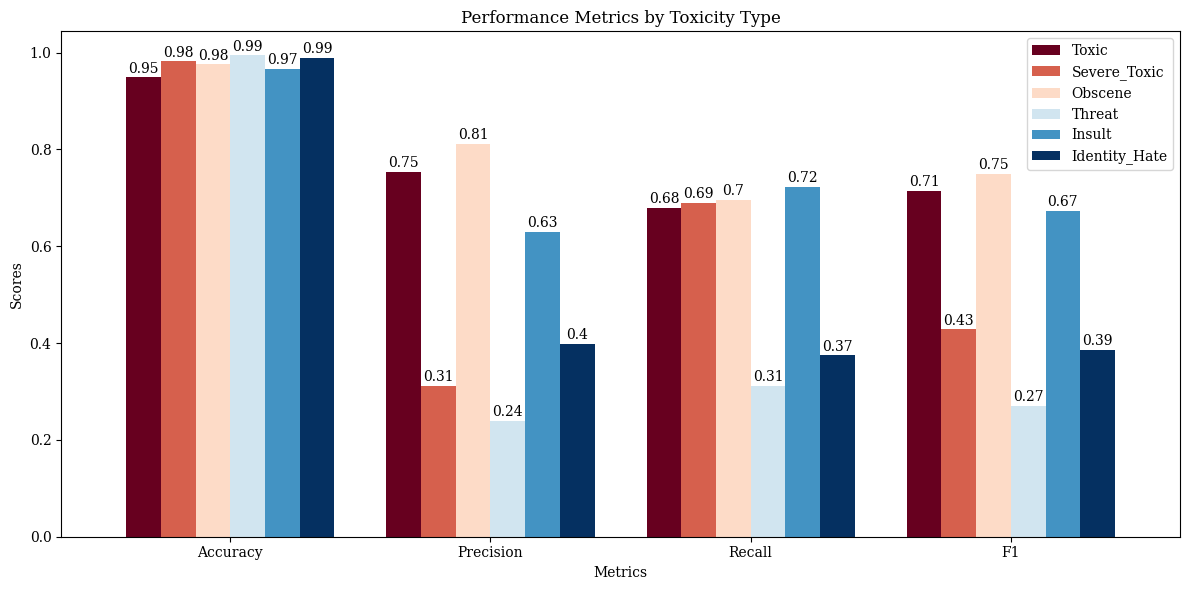

In [ ]:
Model_OverallPerformance(y_pred, y_dev)

From the result, we could see that the DNN model does not perform very well on rare subtypes such as severe toxic, threat, and identity hate.

### VIII. CNN Model

In [ ]:
model_2 = Sequential([])
model_2.add(layers.Input(shape = (maxlen, )))
model_2.add(layers.Embedding(embedding_matrix.shape[0],
                             embedding_matrix.shape[1],
                             weights = [embedding_matrix]))
model_2.add(layers.Conv1D(128, 5, activation = 'relu'))
model_2.add(layers.GlobalMaxPool1D())
model_2.add(layers.Dense(50, activation = 'relu'))
model_2.add(layers.Dropout(0.1))
model_2.add(layers.Dense(6, activation = 'sigmoid'))

In [ ]:
model_2.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 50, 100)           2000000   
                                                                 
 conv1d_7 (Conv1D)           (None, 46, 128)           64128     
                                                                 
 global_max_pooling1d_6 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_17 (Dense)            (None, 50)                6450      
                                                                 
 dropout_9 (Dropout)         (None, 50)                0         
                                                                 
 dense_18 (Dense)            (None, 6)                 306       
                                                     

In [ ]:
model_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=[f1_m])

In [ ]:
model_2.fit(tokens_train, y_train, batch_size= 50, epochs= 5, validation_split=0.1);

Epoch 1/5
2298/2298 [==============================] - 90s 39ms/step - loss: 0.0623 - f1_m: 0.6171 - val_loss: 0.0519 - val_f1_m: 0.6548
Epoch 2/5
2298/2298 [==============================] - 89s 39ms/step - loss: 0.0461 - f1_m: 0.7077 - val_loss: 0.0518 - val_f1_m: 0.6823
Epoch 3/5
2298/2298 [==============================] - 94s 41ms/step - loss: 0.0385 - f1_m: 0.7484 - val_loss: 0.0558 - val_f1_m: 0.6935
Epoch 4/5
2298/2298 [==============================] - 76s 33ms/step - loss: 0.0314 - f1_m: 0.7929 - val_loss: 0.0648 - val_f1_m: 0.6828
Epoch 5/5
2298/2298 [==============================] - 75s 33ms/step - loss: 0.0255 - f1_m: 0.8401 - val_loss: 0.0654 - val_f1_m: 0.6833


In [ ]:
y_pred = model_2.predict([tokens_dev], batch_size=50, verbose=1)

639/639 [==============================] - 6s 9ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Toxic,Severe_Toxic,Obscene,Threat,Insult,Identity_Hate
Accuracy,0.9556,0.9854,0.9791,0.9964,0.9714,0.9917
Precision,0.7860,0.3590,0.8371,0.4732,0.7014,0.5169
Recall,0.7259,0.6282,0.7466,0.4862,0.7239,0.5018
F1,0.7548,0.4569,0.7893,0.4796,0.7125,0.5092


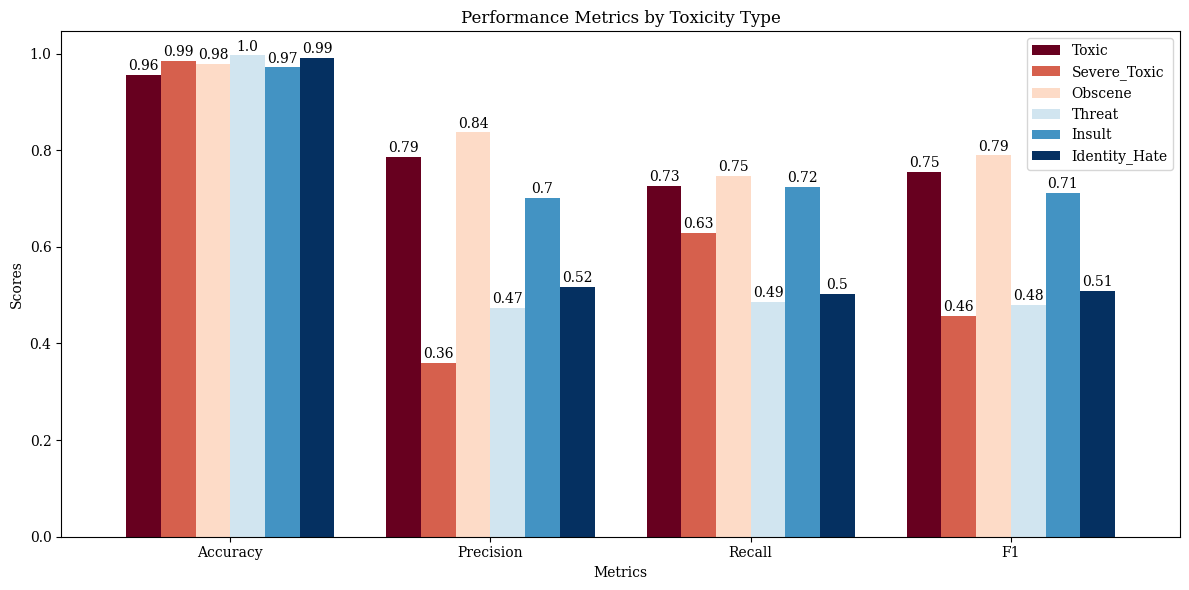

In [ ]:
Model_OverallPerformance(y_pred, y_dev)

The CNN model performs much better than the DNN model, with significant improvement on rare subtypes.

### IX.CNN + LSTM Model

In [ ]:
model_3 = Sequential([])
model_3.add(layers.Input(shape = (maxlen, )))
model_3.add(layers.Embedding(embedding_matrix.shape[0],
                             embedding_matrix.shape[1],
                             weights = [embedding_matrix]))
model_3.add(layers.Conv1D(128, 5, activation = 'relu'))
model_3.add(layers.MaxPool1D())
model_3.add(layers.LSTM(64))
model_3.add(layers.BatchNormalization())
model_3.add(layers.Dense(50, activation = 'relu'))
model_3.add(layers.Dropout(0.1))
model_3.add(layers.Dense(6, activation = 'sigmoid'))

In [ ]:
model_3.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 50, 100)           2000000   
                                                                 
 conv1d_11 (Conv1D)          (None, 46, 128)           64128     
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 23, 128)          0         
 1D)                                                             
                                                                 
 lstm_4 (LSTM)               (None, 64)                49408     
                                                                 
 batch_normalization_7 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dense_23 (Dense)            (None, 50)              

In [ ]:
model_3.compile(loss='binary_crossentropy', optimizer='adam', metrics=[f1_m])

In [ ]:
model_3.fit(tokens_train, y_train, batch_size= 50, epochs= 5, validation_split=0.1);

Epoch 1/5
2298/2298 [==============================] - 123s 52ms/step - loss: 0.0717 - f1_m: 0.6101 - val_loss: 0.0528 - val_f1_m: 0.6904
Epoch 2/5
2298/2298 [==============================] - 118s 51ms/step - loss: 0.0503 - f1_m: 0.6966 - val_loss: 0.0515 - val_f1_m: 0.6980
Epoch 3/5
2298/2298 [==============================] - 116s 51ms/step - loss: 0.0437 - f1_m: 0.7276 - val_loss: 0.0546 - val_f1_m: 0.6912
Epoch 4/5
2298/2298 [==============================] - 116s 51ms/step - loss: 0.0370 - f1_m: 0.7633 - val_loss: 0.0565 - val_f1_m: 0.7052
Epoch 5/5
2096/2298 [==========================>...] - ETA: 10s - loss: 0.0308 - f1_m: 0.8095

In [ ]:
y_pred = model_3.predict([tokens_dev], batch_size=50, verbose=1)

639/639 [==============================] - 11s 17ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Toxic,Severe_Toxic,Obscene,Threat,Insult,Identity_Hate
Accuracy,0.9580,0.9872,0.9789,0.9967,0.9692,0.9916
Precision,0.8040,0.3996,0.8051,0.5263,0.6590,0.5169
Recall,0.7329,0.6122,0.7878,0.2752,0.7662,0.4436
F1,0.7668,0.4835,0.7964,0.3614,0.7085,0.4775


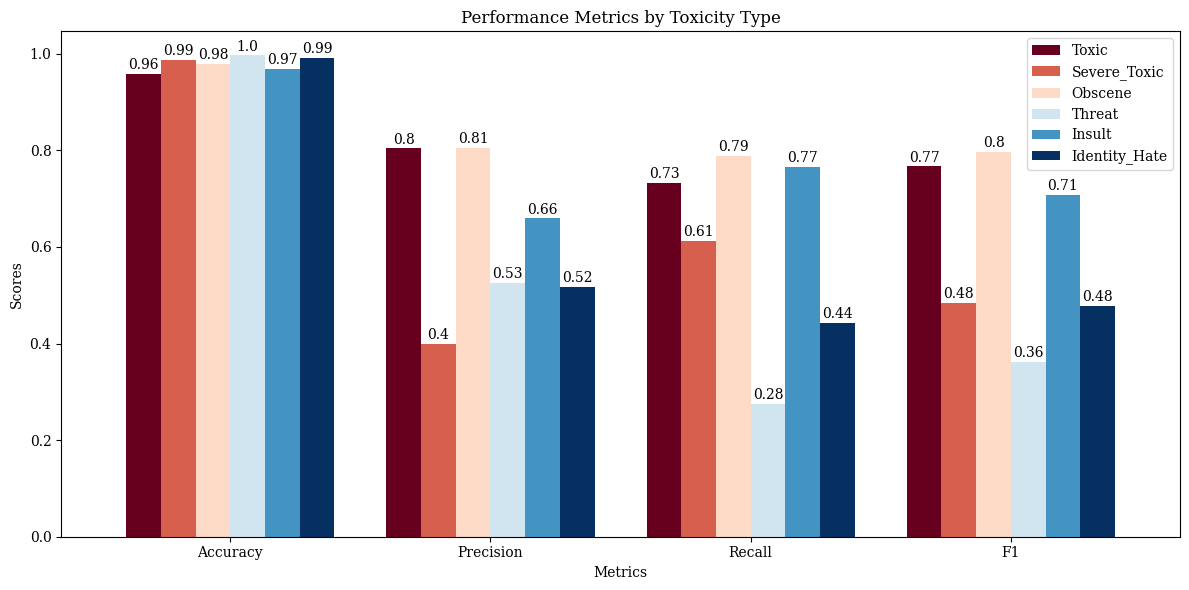

In [ ]:
Model_OverallPerformance(y_pred, y_dev)

The CNN + LSTM model does not perform better than the CNN model.

### X. RNN BLSTM Models

In [ ]:
## 1 layer of BLSTM
model_4 = Sequential([])

model_4.add(layers.Input(shape=(maxlen,)))
model_4.add(layers.Embedding(embedding_matrix.shape[0], 
                           embedding_matrix.shape[1], 
                           weights=[embedding_matrix]))
model_4.add(layers.Bidirectional(layers.LSTM(50,  return_sequences=True)))
model_4.add(layers.GlobalMaxPool1D())
model_4.add(layers.Dense(50, activation='relu'))
model_4.add(layers.Dropout(0.1))
model_4.add(layers.Dense(6, activation="sigmoid"))

In [ ]:
model_4.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 50, 100)           2000000   
                                                                 
 bidirectional (Bidirectiona  (None, 50, 100)          60400     
 l)                                                              
                                                                 
 global_max_pooling1d_7 (Glo  (None, 100)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_25 (Dense)            (None, 50)                5050      
                                                                 
 dropout_13 (Dropout)        (None, 50)                0         
                                                                 
 dense_26 (Dense)            (None, 6)               

In [ ]:
model_4.compile(loss='binary_crossentropy', optimizer='adam', metrics=[f1_m])

In [ ]:
model_4.fit(tokens_train, y_train, batch_size= 50, epochs= 5, validation_split=0.1);

Epoch 1/5
2298/2298 [==============================] - 169s 72ms/step - loss: 0.0625 - f1_m: 0.6181 - val_loss: 0.0496 - val_f1_m: 0.6926
Epoch 2/5
2298/2298 [==============================] - 159s 69ms/step - loss: 0.0453 - f1_m: 0.7195 - val_loss: 0.0486 - val_f1_m: 0.6890
Epoch 3/5
2298/2298 [==============================] - 157s 68ms/step - loss: 0.0394 - f1_m: 0.7480 - val_loss: 0.0492 - val_f1_m: 0.7080
Epoch 4/5
2298/2298 [==============================] - 161s 70ms/step - loss: 0.0343 - f1_m: 0.7839 - val_loss: 0.0519 - val_f1_m: 0.7141
Epoch 5/5
2298/2298 [==============================] - 165s 72ms/step - loss: 0.0296 - f1_m: 0.8105 - val_loss: 0.0553 - val_f1_m: 0.7090


In [ ]:
y_pred = model_4.predict([tokens_dev], batch_size=50, verbose=1)

639/639 [==============================] - 21s 29ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Toxic,Severe_Toxic,Obscene,Threat,Insult,Identity_Hate
Accuracy,0.9580,0.9869,0.9801,0.9971,0.9710,0.9930
Precision,0.8023,0.3949,0.8313,0.5800,0.6867,0.6294
Recall,0.7359,0.6442,0.7776,0.5321,0.7470,0.4509
F1,0.7677,0.4896,0.8036,0.5550,0.7156,0.5254


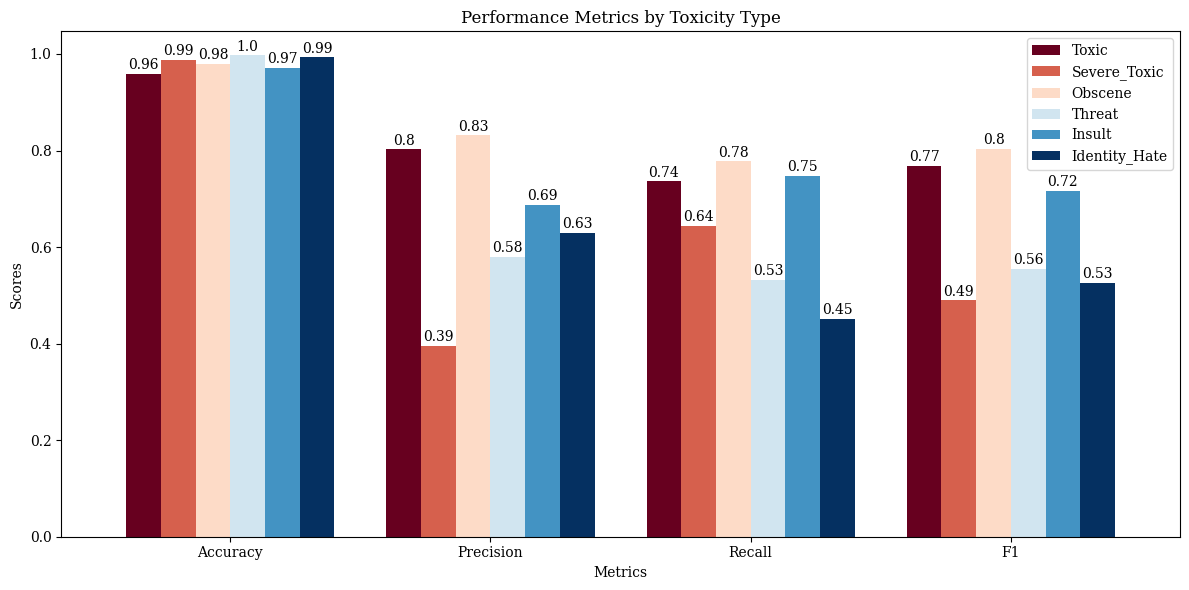

In [ ]:
Model_OverallPerformance(y_pred, y_dev)

The BLSTM model has the best performance so far.

In [ ]:
# 2 layers of BLSTM
model_5 = Sequential([])

model_5.add(layers.Input(shape=(maxlen,)))
model_5.add(layers.Embedding(embedding_matrix.shape[0], 
                           embedding_matrix.shape[1], 
                           weights=[embedding_matrix]))
model_5.add(layers.Bidirectional(layers.LSTM(50,  return_sequences=True)))
model_5.add(layers.Bidirectional(layers.LSTM(50,  return_sequences=True)))
model_5.add(layers.BatchNormalization())
model_5.add(layers.GlobalMaxPool1D())
model_5.add(layers.Dense(50, activation='relu'))
model_5.add(layers.Dropout(0.1))
model_5.add(layers.Dense(6, activation="sigmoid"))

In [ ]:
model_5.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_25 (Embedding)    (None, 50, 100)           2000000   
                                                                 
 bidirectional_12 (Bidirecti  (None, 50, 100)          60400     
 onal)                                                           
                                                                 
 bidirectional_13 (Bidirecti  (None, 50, 100)          60400     
 onal)                                                           
                                                                 
 batch_normalization_11 (Bat  (None, 50, 100)          400       
 chNormalization)                                                
                                                                 
 global_max_pooling1d_17 (Gl  (None, 100)              0         
 obalMaxPooling1D)                                   

In [ ]:
model_5.compile(loss='binary_crossentropy', optimizer='adam', metrics=[f1_m])

In [ ]:
model_5.fit(tokens_train, y_train, batch_size= 50, epochs= 5, validation_split=0.1);

Epoch 1/5
2298/2298 [==============================] - 303s 129ms/step - loss: 0.0621 - f1_m: 0.6260 - val_loss: 0.0507 - val_f1_m: 0.7094
Epoch 2/5
2298/2298 [==============================] - 286s 124ms/step - loss: 0.0466 - f1_m: 0.7068 - val_loss: 0.0479 - val_f1_m: 0.7189
Epoch 3/5
2298/2298 [==============================] - 286s 124ms/step - loss: 0.0408 - f1_m: 0.7311 - val_loss: 0.0499 - val_f1_m: 0.7105
Epoch 4/5
2298/2298 [==============================] - 287s 125ms/step - loss: 0.0355 - f1_m: 0.7672 - val_loss: 0.0536 - val_f1_m: 0.6969
Epoch 5/5
2298/2298 [==============================] - 280s 122ms/step - loss: 0.0308 - f1_m: 0.7984 - val_loss: 0.0583 - val_f1_m: 0.7076


In [ ]:
y_pred = model_5.predict([tokens_dev], batch_size=50, verbose=1)

639/639 [==============================] - 19s 28ms/step


,Toxic,Severe_Toxic,Obscene,Threat,Insult,Identity_Hate
Accuracy,0.9597,0.9876,0.9813,0.9966,0.9718,0.9916
Precision,0.8292,0.4094,0.8567,0.5132,0.7021,0.5144
Recall,0.7206,0.6154,0.7717,0.3578,0.7367,0.5200
F1,0.7711,0.4917,0.8119,0.4216,0.7190,0.5172


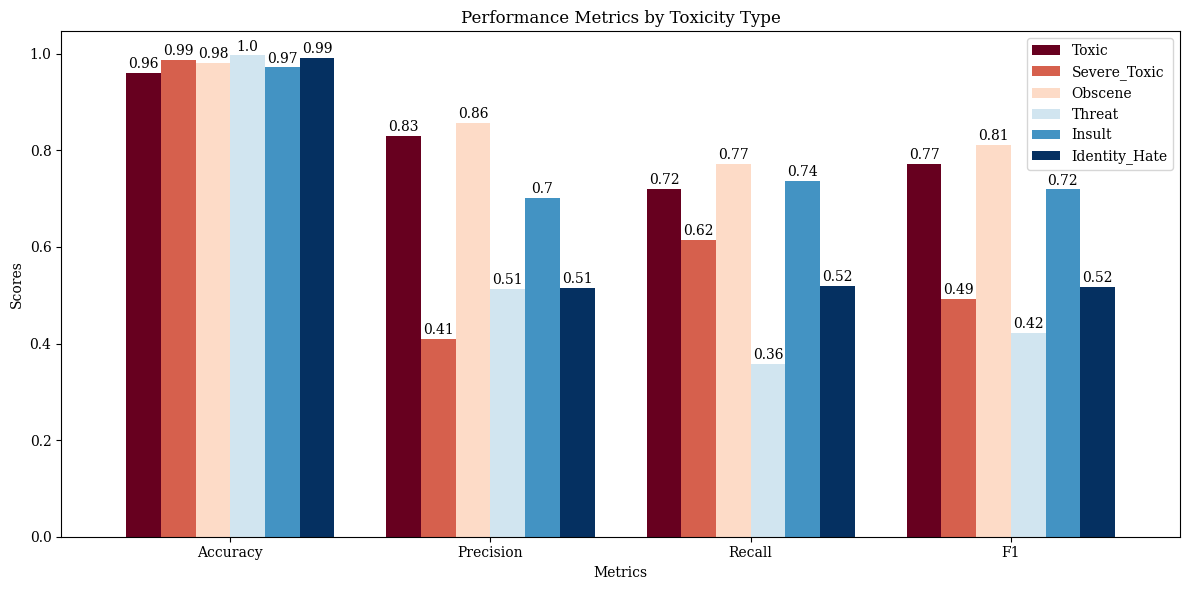

In [ ]:
Model_OverallPerformance(y_pred, y_dev)

Two layers of BLSTM do not perform better than one layer of BLSTM. Possibly related to overfitting.